
# Model eigenvalues  

Eigenvalues are a fundamental concept in dynamic models. In simple terms, they summarize the adjustment process within a model. In the context of dynamic models, the sign and magnitude of the eigenvalues determine whether a system of equations will converge to a stable equilibrium, oscillate, or diverge. 

In the case of a macromodel, which is effectively a system of differential equations, the eigenvalues of the coefficient matrix determine whether the system is stable, marginally stable, or unstable. If all the eigenvalues have negative real parts, then the system is stable and will converge to a steady state over time. If at least one eigenvalue has a positive real part, then the system is unstable, and the solutions will diverge over time.


The modelflow library includes a range of methods to calculate the eigenvalues of a model, which can be used to help to assure that a model's dynamics will be stable and to identify sources of instability where they exist.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#This is code to manage dependencies if the notebook is executed in the google colab cloud service
if 'google.colab' in str(get_ipython()):
  import os
  os.system('apt -qqq install graphviz')
  os.system('pip -qqq install ModelFlowIb ipysheet  --no-dependencies ')


In [2]:
# Prepare the notebook for use of modelflow 

# Jupyter magic command to improve the display of charts in the Notebook
%matplotlib inline

# Import pandas 
import pandas as pd

# Import the model class from the modelclass module 
from modelclass import model 

# functions that improve rendering of modelflow outputs
model.widescreen()
model.scroll_off();

<IPython.core.display.Javascript object>

## Import modelnewton

To calculate eigenvectors and eigenvalues of a model requires thate the newton_diff package from the modelnewton library (part of the modelflow package) be imported.

In [3]:
# Import to handle imaginary numbers 
import numpy as np 

# Import of modelflow lineraization methods. 
from modelnewton import newton_diff

## Load a model, data and descriptions 

For the purposes of this exposition the climate aware model for Pakistan described {cite:author}`burns_climate_2021` is used.

In [4]:
mpak,baseline = model.modelload('../models/pak.pcim')
baseline = mpak(baseline,2023,2100)

file read:  C:\mflow\papers\mfbook\content\models\pak.pcim


:::{index} single: modelflow; .newtondiff() method
:::
:::{index} single: modelnewton package; .newtondiff() method
:::

:::{index} single: model derivatives
:::

:::{index} single: eigenvalues and eigenvectors
:::

:::{index} single: modelflow; eigenvalues and eigenvectors
:::
## the method .newton_diff()

The `modelnewton` method `.newtondiff()` calculates the derivatives of the mpak model, and in the code block belows assigns the results to the object mpak_newton.


In [6]:
mpak_newton_long = newton_diff(mpak,forcenum=0)      # create a newton_diff instance which contains derivatives 

:::{index} single: eigenvalyues; .get_eigenvalues() method
:::
:::{index} single: modelflow; .get_eigenvalues() method
:::

### .get_eigenvalues method
The get_eigenvectors function calculates the actual eigenvectors of the model.  For a large model this can be a fairly time consuming calculation taking several minutes even on relatively powerful multicore i9 computers.

:::{index} single: modelflow; .get_eigplot_all() method
:::
:::{index} single: eqigenvalues; .get_eigplot_all() method
:::
Once the eigenvalues are calculated they can be displayed graphically with the `.eigplot_all()` method.

In [7]:
eig_dic = mpak_newton_long.get_eigenvectors(filnan = True,silent=False,asdf=1) #  

:::{index} single: modelflow; .get_eigplot_all() method
:::
:::{index} single: eqigenvalues; .get_eigplot_all() method
:::

### .get_eigenplot_all method

The `.get_eigenplot_all()` method plots a polar diagram of the eigenvalues for a given year.  Eigenvalues with real roots are stable, one with negative unreal roots in excess of 1 are unstable.

Inspection of the polar diagrams reveals indicates that most of the eigenvalues are less than one, and that those that have unreal roots (those that appear off of the 0 degree line), only a few have imaginary roots outside of the unit circle which could be a source of model uncertainty.

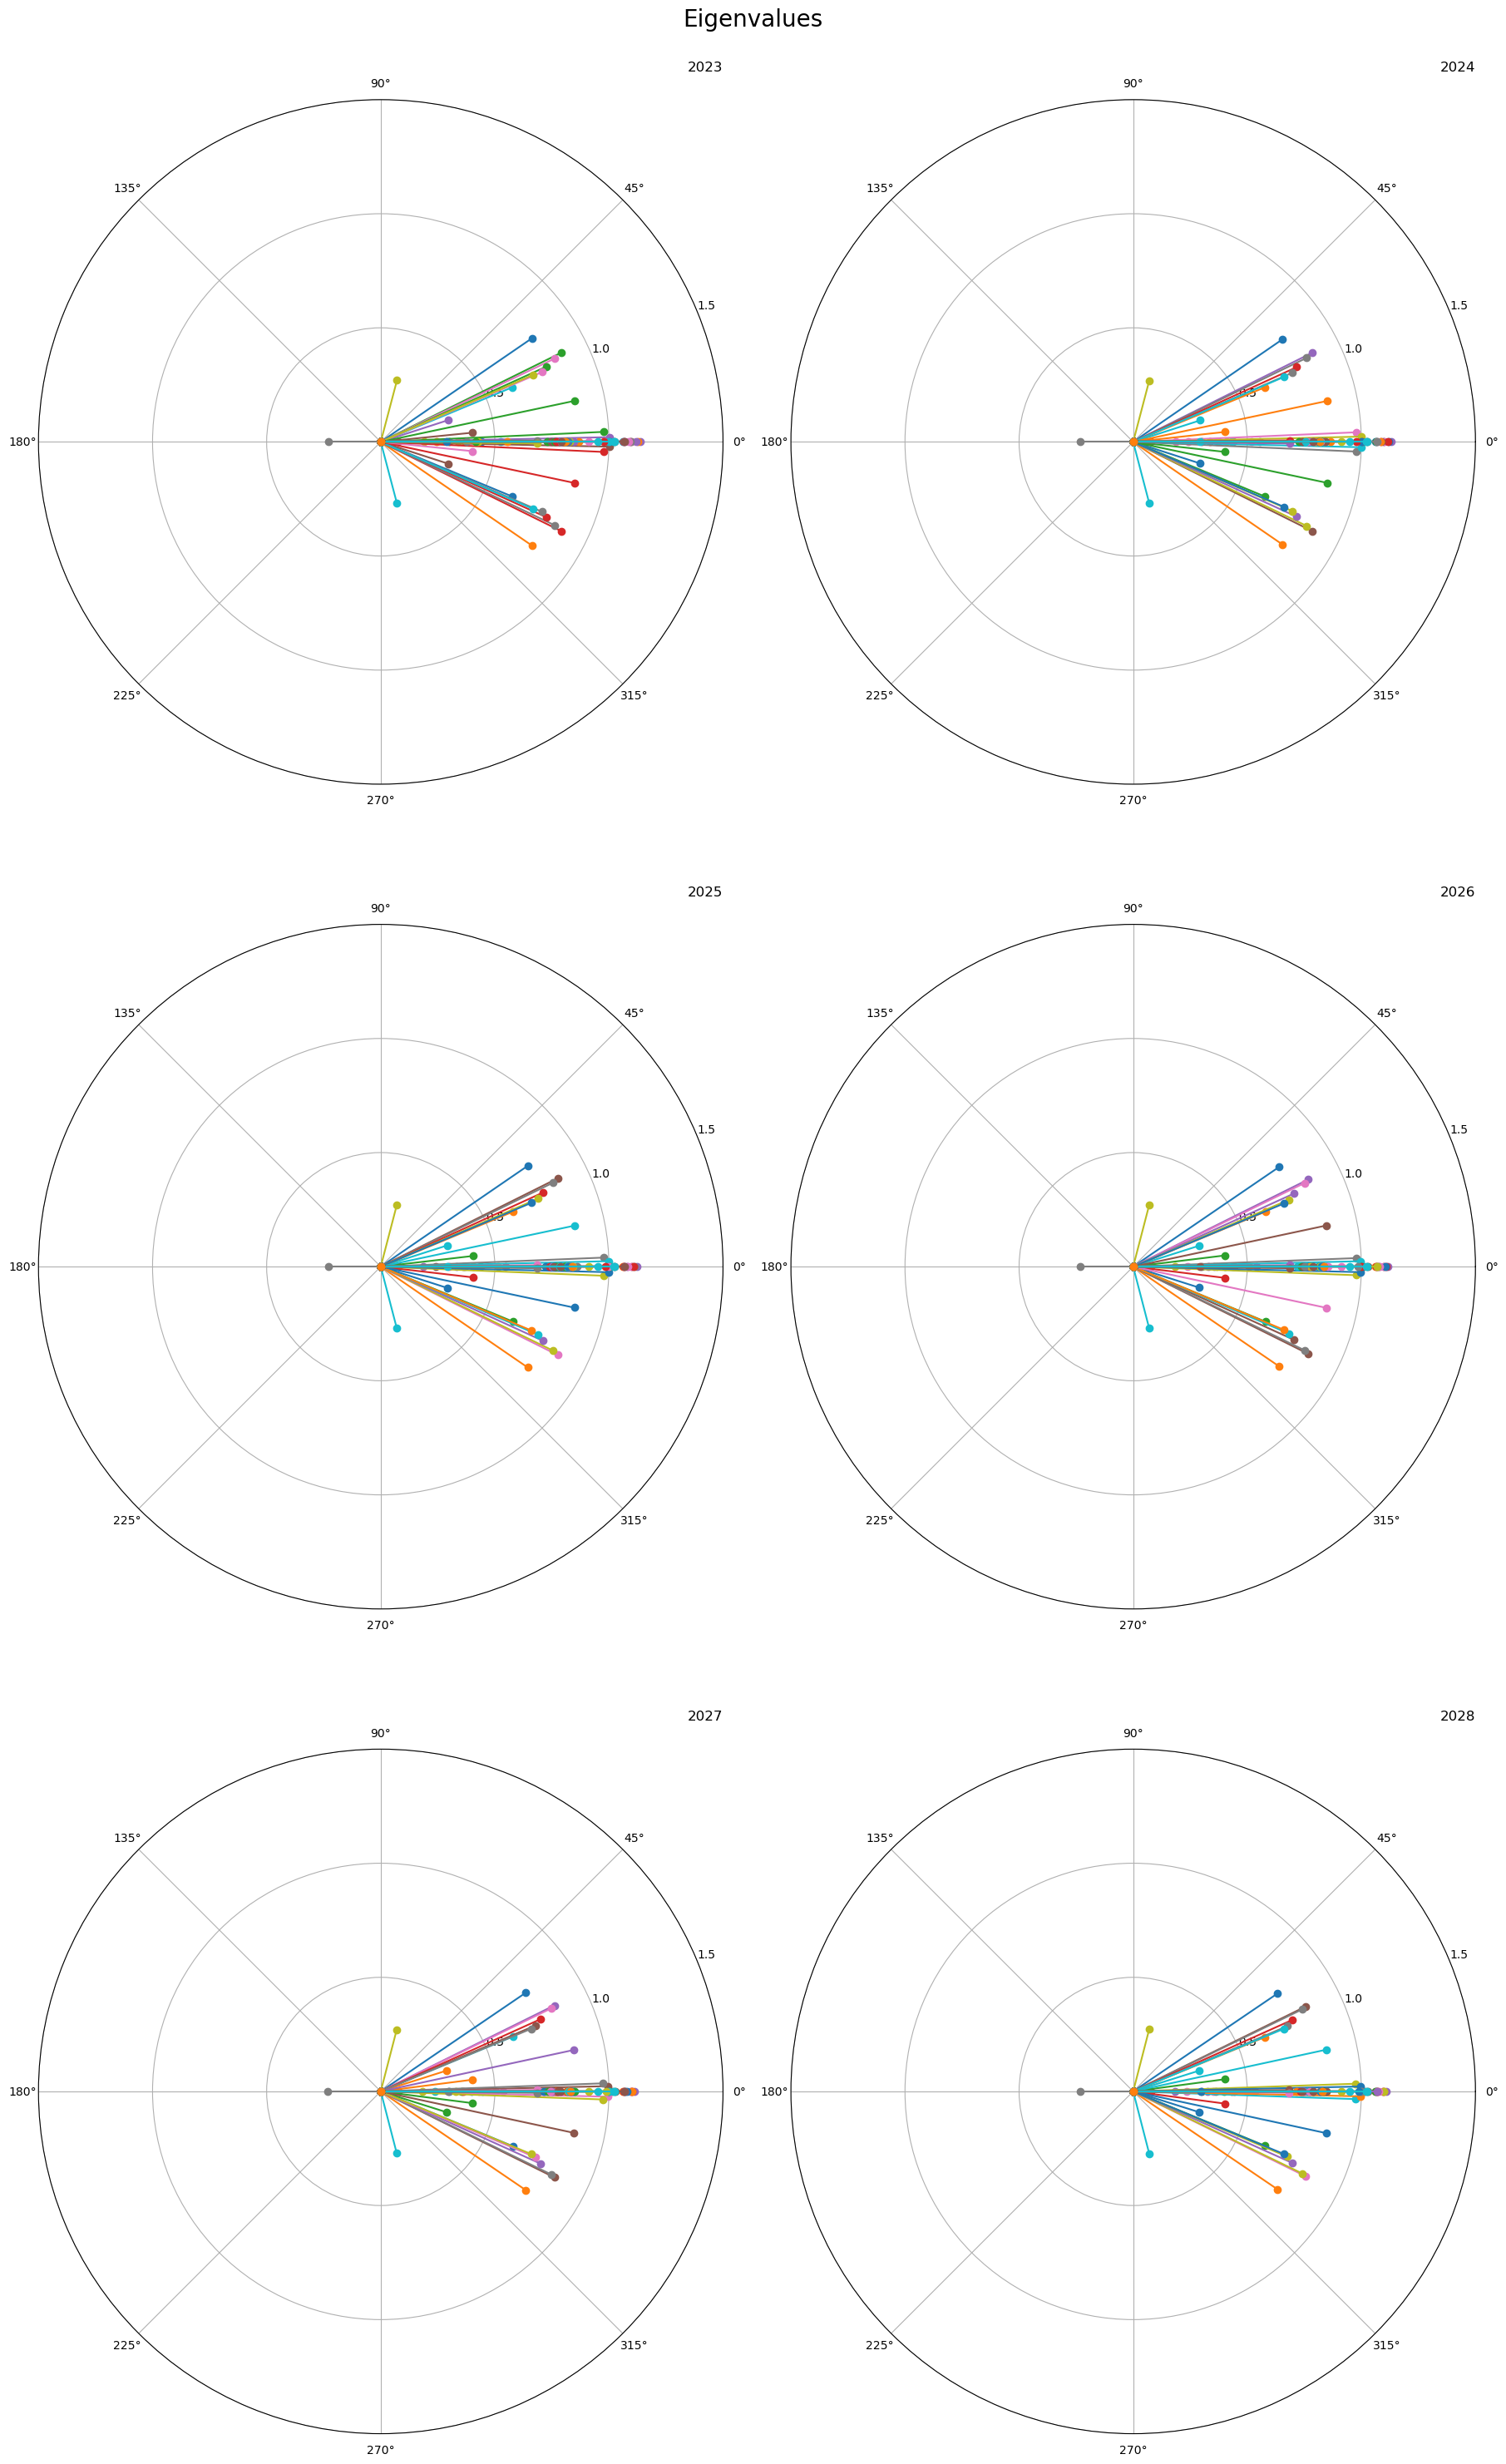

In [8]:
mpak_newton_long.eigplot_all(eig_dic[2023],size=(1,1));

### Isolating potentially problematic eigenvalues

In the charts above it is clear that the vast majority of eigenvalues lie within the real unit circle, implying that the associated equations are dynamically stable.  However, there are several that lie outside of the unit circle.

The code below identifies and prints out those elements whose eigenvalues are greater than one in 2023, and notably and with  with imaginary roots.

In [9]:
eigen = eig_dic[2023]
gt1_no_imag = sorted([(ii,i)  for ii,i in enumerate(eigen) if abs(i) >= 1 and abs(i.imag) < 0.0000000001],reverse=True)
gt1_imag    = sorted([(ii,i)  for ii,i in enumerate(eigen) if np.abs(i) >= 1 and np.abs(i.imag) >  0.00000001],reverse=True)

print('Eigenvalues with length above 1 and only real: ')
print(*[f'element {ii} length: {abs(i):.5f} ' for ii,i in gt1_no_imag],'  ',sep='\n')
print('Eigenvalues with length above 1 and imaginary: ')
print(*[f'element {ii} length: {abs(i):.5f} {i.real:.5f} {i.imag:.5f}' for ii,i in gt1_imag],sep='\n')



Eigenvalues with length above 1 and only real: 
element 1499 length: 1.02441 
element 1419 length: 1.02000 
element 1325 length: 1.06952 
element 1324 length: 1.06998 
element 1323 length: 1.06368 
element 1320 length: 1.00287 
element 1319 length: 1.06036 
element 1316 length: 1.08554 
element 1307 length: 1.09349 
element 1304 length: 1.12010 
element 1291 length: 1.12521 
element 535 length: 1.00816 
element 495 length: 1.02299 
element 494 length: 1.13663 
element 456 length: 1.09513 
element 455 length: 1.09868 
  
Eigenvalues with length above 1 and imaginary: 
element 1315 length: 1.00303 1.00282 -0.02085
element 1314 length: 1.00303 1.00282 0.02085


These results that 16 eigenvalues exceed 1 and that two exceed one and have imaginary roots.

### Look at all years 

The above routine was run for a single year, the code below can be run for multiple years.  Model data could cause an eigenvalue that was stable in one year to become unstable in another year. 


In [10]:
def print_eigenvalues_summary(eig_dic, print_all=False):
    """
    Prints a summary of eigenvalues with length > 1 

    Args:
    eig_dic (dict): A dictionary where keys are years and values are lists of eigenvalues.
    print_all (bool): If True, prints all years. If False, only prints years with non-zero imaginary eigenvalues.

    Returns:
    None
    """
    length_dict = {year: 
        {'lgt1_no_imag': len([i for i in eigen if abs(i) >= 1 and abs(i.imag) < 0.0000000001]),
         'gt1_imag': len([i for i in eigen if abs(i) >= 1 and i.imag > 0.00000001])} 
        for year, eigen in eig_dic.items()
    }

    print('Eigenvalues with length >= 1')
    for year, res in length_dict.items():
        if print_all or res["gt1_imag"] != 0:
            real_values = res["lgt1_no_imag"]
            imag_values = res["gt1_imag"] if res["gt1_imag"] != 0 else ""
            print(f'{year} With real values {real_values}, with imaginary values {imag_values}')


print_eigenvalues_summary(eig_dic, print_all=False)


Eigenvalues with length >= 1
2023 With real values 16, with imaginary values 1
2031 With real values 15, with imaginary values 1
2053 With real values 15, with imaginary values 1
2054 With real values 16, with imaginary values 1
2055 With real values 15, with imaginary values 1
2056 With real values 16, with imaginary values 1
2057 With real values 16, with imaginary values 1
2058 With real values 16, with imaginary values 1
2059 With real values 16, with imaginary values 1
2062 With real values 18, with imaginary values 1
2063 With real values 18, with imaginary values 1
2064 With real values 17, with imaginary values 1
2092 With real values 17, with imaginary values 1
2094 With real values 17, with imaginary values 1
2098 With real values 16, with imaginary values 1
2100 With real values 16, with imaginary values 1


## Dealing with potential instability

Unfortunately there is no one-to-one relationship between equations and eigenvalues. It may be that certain equations are inherently unstable, error-correction models where the speed of adjustment is greater than one for example.  Equation results can be inspected for such sources of instability.  

Other sources of instability may be more subtle and lie in the interaction of coefficients across equations.  One approach to identifying potentially problematic equations is to perform a grid-search by recalculating the eigenvalues of the system after eliminating one at a time individual equations. The elimination of an ill-formed equation is likely to cause large and greater than one eigenvalues to shrink and potentially even fall within the unit circle and may cause eigenvalues with imaginary roots to disappear.

:::{index} single: stability; .get_eigen_jackknife_df() method
:::
:::{index} single: eigenvalues; .get_eigen_jackknife_df() method
:::
:::{index} single: modelflow; .get_eigen_jackknife_df() method
:::


### The `.get_eigen_jackknife_df()` method

Modelflow includes a jackknife algorithm (`.get_eigen_jackknife_df()`) that systematically drops one-by-one each equation from model, and then recalculates the eigenvalues of the smaller model. The  eigenvalues for each new model are returned as a tall dataframe. 

By keeping track of the size of the largest eigenvalues, it seeks to identify one (or more) equations that have a large influence on the eigenvalues of the system.

For a large model, this can be a time-consuming exercise (7-12 minutes for mpak over two years, depending on the user's processor).


A tall dataframe with the following columns is returned

| Column     | Explanation                                         |
|:-----------|:-----------------------------------------------------|
| excluded   | The name or identifier of the excluded variable.    |
| year       | The year associated with the data row.              |
| index      | The index or position of the row in the dataset.    |
| value      | The computed or observed value for the row.         |
| length     | The absolute length or magnitude of the `value`.    |
| realvalue  | The real part of the `value` if it's complex.       |
| imagvalue  | The imaginary part of the `value` if it's complex.  |
|excluded_description| The description of the variable for which the equation is excluded|


To test code, the parameter maxnames can be set to restrict the number of re-samplings.

The routine sums the 20 largest eigenvalues each time an equation is omitted.  Equations whose omission from the model reduces the largest eigenvalues the most are most likely to be the source of model instability.


### Look at only 2 years
For the sake of execution time a new mpak_newton is created with only 2 years. 

In [6]:
_ = mpak(baseline,2023,2024)
mpak_newton = newton_diff(mpak,forcenum=0)      # create a newton_diff instance which contains derivatives for 2023 and 2024
# eig_dic_short = mpak_newton.get_eigenvectors(filnan = True,silent=False,asdf=1) #  

Below the `get_eigen_jackknife` routine systematically calcualtes the eigenvalue of 303 different versions of the model, the original model and then 302 models equal to the original model less one equation.  This is a time consuming exercise on a model the size of mpak.

In [7]:
jackdf  = mpak_newton.get_eigen_jackknife_df()

Calculating eigenvalues of 303  different matrices takes time, so make cup of coffee and a take a short nap


  0%|          | 0/303 [00:00<?, ?it/s]

### The structure of jackdf

The dataframe returned by the routine contains a stacked (tall) dataframe showing the all the eigenvalue, and their assocaited levels length, real and imaginary values for each variant of the model.  The excluded column indicates what equation was excluded and he exclude description gives a more verbose indication of the change.  The first set of eigenvalues are for the whole model and the last are for the model when the last equation () is excluded.

In [8]:
jackdf.head()

excluded  year  index     value  length  realvalue  imagvalue   
0     NONE  2023      0  0.0+0.0j     0.0        0.0        0.0  \
1     NONE  2023      1  0.0+0.0j     0.0        0.0        0.0   
2     NONE  2023      2  0.0+0.0j     0.0        0.0        0.0   
3     NONE  2023      3  0.0+0.0j     0.0        0.0        0.0   
4     NONE  2023      4  0.0+0.0j     0.0        0.0        0.0   

  excluded_description  
0          whole model  
1          whole model  
2          whole model  
3          whole model  
4          whole model

In [9]:
jackdf.tail()

excluded  year  index     value  length  realvalue  imagvalue   
916867  TURPCEXN05  2024   1503  0.0+0.0j     0.0        0.0        0.0  \
916868  TURPCEXN05  2024   1504  0.0+0.0j     0.0        0.0        0.0   
916869  TURPCEXN05  2024   1505  0.0+0.0j     0.0        0.0        0.0   
916870  TURPCEXN05  2024   1506  0.0+0.0j     0.0        0.0        0.0   
916871  TURPCEXN05  2024   1507  0.0+0.0j     0.0        0.0        0.0   

       excluded_description  
916867           TURPCEXN05  
916868           TURPCEXN05  
916869           TURPCEXN05  
916870           TURPCEXN05  
916871           TURPCEXN05

## Examining the results of the grid search

The query command allows to return all rows from the dataframe that match a given criteria.  In this case, it asks for all rows where excluded is = NONE (i.e.where no variable was excluded) **and** the absolute value of the imaginary number of the eigenvector is not 0 **and** the year is 2003.

As it turns out, there is only one eigenvalue with length greater than one and  and imaginary value different from 0 (recall imaginary values always return in pairs: a positive number and the numerically identical  negative number). 



In [14]:
jackdf.query('excluded =="NONE" & length > 1 & abs(imagvalue) != 0.0 &  year == 2023')

excluded  year  index               value    length  realvalue  \
1316     NONE  2023   1316  1.002817+0.020852j  1.003034   1.002817   
1317     NONE  2023   1317  1.002817-0.020852j  1.003034   1.002817   

      imagvalue excluded_description  
1316   0.020852          whole model  
1317  -0.020852          whole model

##  Which equations can be deleted, and there will still be a length > 1 and imaginary value different from 0. 
Apparently for  285 equations the model is still unstable if the equations is deleted.  

In [15]:
jackdf.query('length > 1 & imagvalue > 0.0 &  year == 2023')

excluded  year  index               value    length  realvalue  \
1316            NONE  2023   1316  1.002817+0.020852j  1.003034   1.002817   
4343        CHNEXR05  2023   1319  1.002817+0.020852j  1.003034   1.002817   
7363      CHNPCEXN05  2023   1323  1.002817+0.020852j  1.003034   1.002817   
10379       DEUEXR05  2023   1323  1.002817+0.020852j  1.003034   1.002817   
13392     DEUPCEXN05  2023   1320  1.002817+0.020852j  1.003034   1.002817   
...              ...   ...    ...                 ...       ...        ...   
903110  PAKWHSLINTKN  2023   1318  1.002817+0.020852j  1.003034   1.002817   
906115       PAKXMKT  2023   1307  1.002817+0.020852j  1.003034   1.002817   
909130    PAKXMKT_GR  2023   1306  1.002817+0.020852j  1.003034   1.002817   
912146      TUREXR05  2023   1306  1.002817+0.020852j  1.003034   1.002817   
915162    TURPCEXN05  2023   1306  1.002817+0.020852j  1.003034   1.002817   

        imagvalue                     excluded_description  
1316     0.020852                              whole model  
4343     0.020852                                 CHNEXR05  
7363     0.020852                               CHNPCEXN05  
10379    0.020852                                 DEUEXR05  
13392    0.020852                               DEUPCEXN05  
...           ...                                      ...  
903110   0.020852                             PAKWHSLINTKN  
906115   0.020852  PAKXMKT Weighted Trading Partner Demand  
909130   0.020852                               PAKXMKT_GR  
912146   0.020852                                 TUREXR05  
915162   0.020852                               TURPCEXN05  

[287 rows x 8 columns]

## Identifying potentially troublesome

To identify potentially troublesome equations we interrogate the database for submodels, which when a specific equations is omitted no-longer have eigenvalues greater than one that also have imaginary roots.

Effectively if, when an equation is excluded from the model, the truncated model has no eigenvalue outside the unit root with imaginary roots -- that suggests quite striongly that the excluded equation plays is playing a part in the instability of the model. 

The procedure below goes through the tall dataframe and returns only those rows where no eigenvalue for the group identified by the excluded variable has an eigenavlue >1 and imaginary roots.  For these variables exclusion of its equation eliminated the instability in the residual model.



In [10]:
def get_unique_excluded(df, year, excluded_col='excluded', description_col='excluded_description'):
    """
    Filters the DataFrame for a specific year and returns unique values of 'excluded' and their descriptions,
    where no row in the group satisfies both conditions (length > 1 and imagvalue > 0).

    Args:
    df (pandas.DataFrame): The DataFrame to process.
    year (int): The year to filter the DataFrame.
    excluded_col (str): The name of the column containing excluded variables. Default is 'excluded'.
    description_col (str): The name of the column containing descriptions of excluded variables. Default is 'excluded_description'.

    Returns:
    tuple: A tuple containing two arrays - unique excluded descriptions and unique excluded variables.
    """
    # Filter DataFrame for the specified year and apply the conditions
    filtered_df = df.query('year == @year').groupby(excluded_col).filter(
        lambda x: ~((x['length'] > 1) & (x['imagvalue'] > 0)).any()
    )

    # Extract unique values
    unique_descriptions = filtered_df[description_col].unique()
    unique_variables = filtered_df[excluded_col].unique()

    return unique_descriptions, unique_variables

unique_excluded_descriptions, unique_excluded_variables = get_unique_excluded(jackdf, 2023)
print(unique_excluded_descriptions)


['PAKGGDBTTOTLCN General government gross debt millions lcu'
 'PAKGGEXPCAPTCN General government expenditure on capital expenditure (millions lcu)'
 'PAKGGEXPINTPCN General government interest payments on public debt (millions lcu)'
 'PAKGGREVTOTLCN General government revenues, total (millions lcu)'
 'PAKNECONGOVTCN Govt. Cons., LCU mn' 'PAKNECONGOVTKN Gov. Cons real'
 'PAKNECONOTHRXN' 'PAKNECONPRVTCN Pvt. Cons., LCU mn'
 'PAKNECONPRVTXN Implicit LCU defl., Pvt. Cons., 2000 = 1'
 'PAKNEGDIFPRVKN Prvt. Investment real' 'PAKNEGDIFTOTKN Investment real'
 'PAKNEGDIFTOTKN2' 'PAKNEGDIKSTKKN Capital stock, LCU'
 'PAKNYGDPFCSTXN GDP Factor Cost Local Currency units Implicit Price deflator'
 'PAKNYGDPGAP_ Output Gap (% of Potential GDP)'
 'PAKNYGDPMKTPCN GDP, Market Prices, LCU mn'
 'PAKNYGDPPOTLKN Potential Output, constant LCU']


## Show the EViews equations for the equations. 

Now that a list of potentially problematic equations has been extracted from the model, their equations can be examined for any obvious factors that might be de-stabilizing, such as a speed of adjustment in an ECM equation that was negative or greater than 2.

For World Bank models the equations are usually easier to read in their estimated form, which can be extracted by passing a space-delimited string of the mnemonics of the selected variables to the the eviews command.

A quick inspection reveals no obvious candidates for an equation that is itself inherently unstable, although by the same token the levels of  several equations are not constrained in several instances.

In [17]:
string_of_excluded_variables = ' '.join(unique_excluded_variables)
mpak[string_of_excluded_variables].eviews

PAKGGDBTTOTLCN  : PAKGGDBTTOTLCN = PAKGGDBTTOTLCN( - 1) - PAKGGBALOVRLCN + PAKGGDBTVALTCN + 0*DUMH
PAKGGEXPCAPTCN  : PAKGGEXPCAPTCN = 0.3*PAKGGEXPCAPTCN( - 1) + (1 - 0.3)*(0.37*(PAKGGREVTOTLCN - PAKGGEXPINTPCN( - 0))) + 393385.011*@DURING("2013")
PAKGGEXPINTPCN  : @IDENTITY PAKggexpintpcn  = PAKggexpintecn  + PAKggexpintdcn
PAKGGREVTOTLCN  : @IDENTITY PAKGGREVTOTLCN  = (PAKGGREVOTHRCN  + PAKGGREVDRCTCN  + PAKGGREVGRNTCN  + PAKGGREVGNFSCN  + PAKGGREVTRDECN  + PAKGGREVEMISCN)  + (PAKinsu  + PAKcofu)  * PAKPAYOUTCN
PAKNECONGOVTCN  : @PC(PAKNECONGOVTCN) = @PC(PAKGGEXPGNFSCN) + 0.764199817873939*DUMH
PAKNECONGOVTKN  : @IDENTITY PAKNEcongovtkn  = PAKNEcongovtcn  / PAKNEcongovtxn
PAKNECONOTHRXN  : DLOG(PAKNECONOTHRXN) = 0.590372627657176*DLOG(PAKNYGDPFCSTXN) + D(PAKGGREVGNFSXN/100) + (1 - 0.590372627657176)*DLOG(PAKNEIMPGNFSXN) + 0.2*PAKNYGDPGAP_/100
PAKNECONPRVTCN  : @IDENTITY PAKNECONPRVTCN  = PAKNECONPRVTKN  * PAKNECONPRVTXN
PAKNECONPRVTXN  : @IDENTITY PAKNECONPRVTXN  = ((PAKNECONENGYSH^PA

## Show the modelflow equations. 

The equations can also be inspected in their normalized level form.

In [18]:
mpak[string_of_excluded_variables].frml

PAKGGDBTTOTLCN  : FRML <DAMP,STOC> PAKGGDBTTOTLCN = (PAKGGDBTTOTLCN(-1)-PAKGGBALOVRLCN+PAKGGDBTVALTCN+0*DUMH + PAKGGDBTTOTLCN_A)* (1-PAKGGDBTTOTLCN_D)+ PAKGGDBTTOTLCN_X*PAKGGDBTTOTLCN_D $
PAKGGEXPCAPTCN  : FRML <DAMP,STOC> PAKGGEXPCAPTCN = (0.3*PAKGGEXPCAPTCN(-1)+(1-0.3)*(0.37*(PAKGGREVTOTLCN-PAKGGEXPINTPCN(-0)))+393385.011*DURING_2013 + PAKGGEXPCAPTCN_A)* (1-PAKGGEXPCAPTCN_D)+ PAKGGEXPCAPTCN_X*PAKGGEXPCAPTCN_D $
PAKGGEXPINTPCN  : FRML <IDENT> PAKGGEXPINTPCN = PAKGGEXPINTECN+PAKGGEXPINTDCN $
PAKGGREVTOTLCN  : FRML <IDENT> PAKGGREVTOTLCN = (PAKGGREVOTHRCN+PAKGGREVDRCTCN+PAKGGREVGRNTCN+PAKGGREVGNFSCN+PAKGGREVTRDECN+PAKGGREVEMISCN)+(PAKINSU+PAKCOFU)*PAKPAYOUTCN $
PAKNECONGOVTCN  : FRML <DAMP,STOC> PAKNECONGOVTCN = (PAKNECONGOVTCN_A*PAKNECONGOVTCN(-1)/100+ ((100 * ( (PAKGGEXPGNFSCN) / (PAKGGEXPGNFSCN(-1)) -1)) +0.764199817873939*DUMH) *PAKNECONGOVTCN(-1)/100+PAKNECONGOVTCN(-1)) * (1-PAKNECONGOVTCN_D)+ PAKNECONGOVTCN_X*PAKNECONGOVTCN_D $
PAKNECONGOVTKN  : FRML <IDENT> PAKNECONGOVTKN = PAKNE

# Drawing conclusions about the instability in the model


Interestingly the returned variables include four variables surrounding the government accounts.  Indicating that left to its own devices the equations for government spending could send the model into an unstable state.   While from a technical solution of a system of differential equations  point of view this might be worrisome, from an economic point of view this is actually a desirable feature.

It indicates that in the absence of a fiscal rule to constrain spending or to ensure revenues expand, it is possible for the government debt to grow in an unstable manner, causing model instability. 

The economic translation of that condition is that there is nothing in the estimated behaviour of government spending and revenues to prevent a debt crisis from emerging, an indeed Pakistan is a country that has found itself fin debt distress in several instances, so this model "instability" would appear to reflect a real instability in the economy and as such may be a desirable feature.  Elimination (which is to say exogenization of government expenditure would be sufficient to eliminate the risk of instability.

The other unconstrained variables are the price variables.  Again this is not a problem for economic theory, which advises that the rate of inflation should stabilize but says nothing about the price level -- which indeed has a tendency inmost countries to increase over time -- although in most cases not exponentially.